In [ ]:
import pandas as pd
import numpy as np   
import matplotlib.pyplot as plt  

df = pd.read_csv('/work/turkey_earthquakes(1915-2023_may).csv')  #read dataframe

# Data Preprocessing

In [ ]:
#check datatypes and nulls
print(df.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19908 entries, 0 to 19907
Data columns (total 15 columns):
 #   Column                                                                                  Non-Null Count  Dtype  
---  ------                                                                                  --------------  -----  
 0   No                                                                                      19908 non-null  int64  
 1   Earthquake Code                                                                         19908 non-null  float64
 2   Date of occurrence                                                                      19908 non-null  object 
 3   Time of occurrence                                                                      19908 non-null  object 
 4   Latitude                                                                                19908 non-null  float64
 5   Longitude                                                          

In [ ]:
#rename columns for readability
df.rename(columns={'xM            The largest value among the given magnitude (MD, ML, Mw, Ms, Mb) values.': 'Largest Magnitude'}, inplace=True) 
df.head()

,No,Earthquake Code,Date of occurrence,Time of occurrence,Latitude,Longitude,Depth,Largest Magnitude,MD,ML,Mw,Ms,Mb,Type,Location
0,1,2.020000e+13,2023.04.30,01:27.7,38.3392,37.7633,8.7,4.3,0.0,4.3,4.3,0.0,0.0,Ke,KEPEZ-AKCADAG (MALATYA) [East 1.7 km]
1,2,2.020000e+13,2023.04.30,02:53.5,40.8077,31.0708,3.7,3.5,0.0,3.5,3.4,0.0,0.0,Ke,PASAKONAGI- (DUZCE) [South West 0.9 km]
2,3,2.020000e+13,2023.04.30,51:22.2,35.6422,34.0252,22.4,3.5,0.0,3.5,3.5,0.0,0.0,Ke,AKDENIZ
3,4,2.020000e+13,2023.04.29,48:32.9,37.8623,36.2185,5.0,4.0,0.0,3.9,4.0,0.0,0.0,Ke,KARAKUYU-SAIMBEYLI (ADANA) [East 1.4 km]
4,5,2.020000e+13,2023.04.29,58:29.2,38.0220,36.4457,5.0,3.7,0.0,3.7,3.4,0.0,0.0,Ke,YIRICEK-GOKSUN (KAHRAMANMARAS) [North West 2....


In [ ]:
#convert date to datetime and extract day, month, year, and time
df['Date of occurrence'] = pd.to_datetime(df['Date of occurrence']) 
df['Year'] = df['Date of occurrence'].dt.year #extract year
df['Month'] = df['Date of occurrence'].dt.month #extract month
df['Day'] = df['Date of occurrence'].dt.day
df['Minutes'] = df['Time of occurrence'].str.split(':').str[0].astype(int)
df['Seconds'] = df['Time of occurrence'].str.split(':').str[1].astype(float)

#export to csv file with only relevant columns for time prediction
time_df = df[['No','Year', 'Month', 'Day', 'Minutes', 'Seconds', 'Largest Magnitude']]
time_df.to_csv('timedata_turkey_earthquakes.csv', index=False) 

In [ ]:
#normalize latitude and longitude values
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['Latitude', 'Longitude']] = scaler.fit_transform(df[['Latitude', 'Longitude']]) 

In [ ]:
#create location class column based on k-means clustering technique
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0)
df['Location_Class'] = kmeans.fit_predict(df[['Latitude', 'Longitude']]) 

In [ ]:
#export to csv file with only relevant columns for location classification
loc_df = df[['No','Latitude', 'Longitude', 'Depth', 'Location_Class', 'Largest Magnitude']]
loc_df.to_csv('locdata_turkey_earthquakes.csv', index=False) 

# Time Prediction

RNN:

2024-01-15 16:28:24.597870: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-15 16:28:24.712935: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 16:28:24.717568: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-15 16:28:24.717588: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

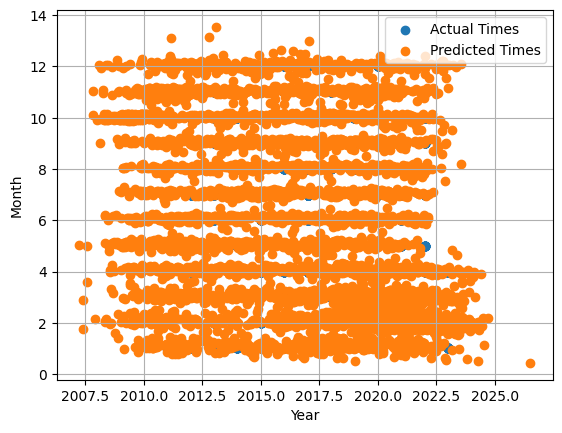

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

# load dataset
file_path = "timedata_turkey_earthquakes.csv"
df = pd.read_csv(file_path)

# split the data into training and testing sets temporally
train_data = df[df['Year'] <= 2010]
test_data = df[df['Year'] > 2010]

# extract relevant features 
train_features = train_data[['Year', 'Month', 'Day', 'Minutes', 'Seconds']]
test_features = test_data[['Year', 'Month', 'Day', 'Minutes', 'Seconds']]

train_target = train_data[['Year', 'Month', 'Day']]
test_target = test_data[['Year', 'Month', 'Day']]

# normalize the data
scaler = MinMaxScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

train_target_scaled = scaler.fit_transform(train_target)
test_target_scaled = scaler.transform(test_target)

# create sequences for time series data
def create_sequences(data, target, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 10  
X_train, y_train = create_sequences(train_features_scaled, train_target_scaled, time_steps)
X_test, y_test = create_sequences(test_features_scaled, test_target_scaled, time_steps)

# build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=3))  # 3 units for year, month, and day
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=80, batch_size=16, validation_data=(X_test, y_test))

# evaluate the model
rnn_loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set: {rnn_loss}')

# make predictions
y_pred = model.predict(X_test)

# inverse transform the predictions and actual values to their original scale
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

# calculate mean squared error and mean absolute error
rnn_mse = mean_squared_error(y_test_original, y_pred_original)
rnn_mae = mean_absolute_error(y_test_original, y_pred_original)
print(f'Mean Squared Error: {rnn_mse}')
print(f'Mean Absolute Error: {rnn_mae}')

# calculate prediction rate
prediction_rate = 1 - (rnn_mae / np.mean(y_test_original))
print(f'Prediction Rate: {prediction_rate * 100:.2f}%')

# compare predictions with actual values
comparison_df = pd.DataFrame({'Actual_Year': y_test_original[:, 0], 'Actual_Month': y_test_original[:, 1], 'Actual_Day': y_test_original[:, 2],
                              'Predicted_Year': y_pred_original[:, 0], 'Predicted_Month': y_pred_original[:, 1], 'Predicted_Day': y_pred_original[:, 2]})
print(comparison_df)

# plot the predicted time series (considering year and month only)
predicted_times = y_pred_original[:, :2].reshape(-1, 2)  
actual_times = y_test_original[:, :2].reshape(-1, 2)

plt.scatter(actual_times[:, 0], actual_times[:, 1], label='Actual Times')
plt.scatter(predicted_times[:, 0], predicted_times[:, 1], label='Predicted Times')
plt.xlabel('Year')
plt.ylabel('Month')
plt.legend()
plt.grid()
plt.show()

LSTM:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# load dataset
file_path = "timedata_turkey_earthquakes.csv"
time_df = pd.read_csv(file_path)

# extract relevant features for prediction
features = df[['Year', 'Month', 'Day', 'Minutes', 'Seconds']]
target = df[['Year', 'Month', 'Day']]  

# split the dataset into training and testing sets temporally
train_data = df[df['Year'] <= 2010]
test_data = df[df['Year'] > 2010]

# normalize the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target)

# create sequences for time series data
def create_sequences(data, target, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 10  
X, y = create_sequences(features_scaled, target_scaled, time_steps)

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# build the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=3, activation='linear'))  # 3 units for year, month, and day 
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# evaluate the model
lstm_loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set: {lstm_loss}')

# make predictions on test set
y_pred = model.predict(X_test)

# inverse transform the predictions and actual values to their original scale
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

# compare predictions with actual values
comparison_df = pd.DataFrame({
    'Actual_Year': y_test_original[:, 0],
    'Actual_Month': y_test_original[:, 1],
    'Actual_Day': y_test_original[:, 2],
    'Predicted_Year': y_pred_original[:, 0],
    'Predicted_Month': y_pred_original[:, 1],
    'Predicted_Day': y_pred_original[:, 2]
})
print(comparison_df)


2024-01-14 10:32:12.424242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-14 10:32:12.525827: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 10:32:12.531498: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-14 10:32:12.531514: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

# Location Classification

Random Forest:

In [ ]:
import pandas as pd
file_path = '/work/locdata_turkey_earthquakes.csv'
df_loc = pd.read_csv(file_path)

# split data
from sklearn.model_selection import train_test_split

X = df_loc[['Latitude', 'Longitude', 'Depth', 'Largest Magnitude']]
y = df_loc['Location_Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=39)

In [ ]:
#implement random forest model
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, random_state=39)

model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=39)

In [ ]:
#evaluate model 
from sklearn.metrics import accuracy_score, precision_score, recall_score

y_pred = model_rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred, average='weighted')
rf_recall = recall_score(y_test, y_pred, average='weighted')

print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)

Accuracy: 0.9963833634719711
Precision: 0.9963885902577869
Recall: 0.9963833634719711


In [ ]:
#prepare a classification map
import geopandas as gpd

gdf = gpd.GeoDataFrame(df_loc, geometry=gpd.points_from_xy(df_loc.Longitude, df_loc.Latitude))

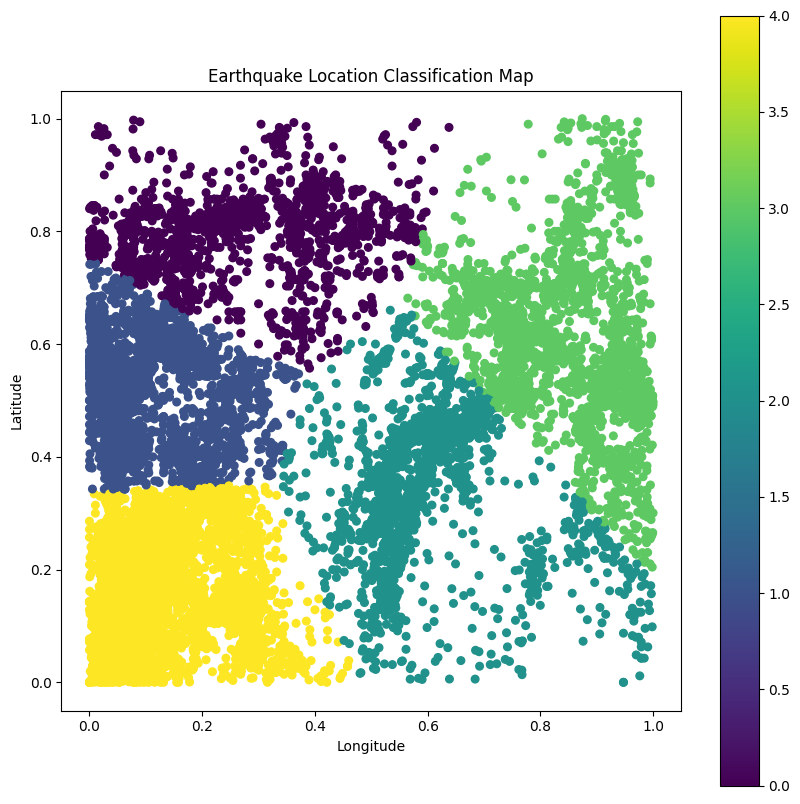

In [ ]:
import matplotlib.pyplot as plt

# plot the points
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column='Location_Class', legend=True, markersize=30, cmap='viridis')

plt.title('Earthquake Location Classification Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [ ]:
#save model
import joblib
joblib.dump(model_rf, 'random_forest_model.joblib')


['random_forest_model.joblib']

SVM:

In [ ]:
import pandas as pd
import geopandas as gpd
file_path = '/work/locdata_turkey_earthquakes.csv'
df_loc = pd.read_csv(file_path)
#implement svm model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import datasets
import matplotlib.pyplot as plt


X = df_loc[['Latitude', 'Longitude', 'Depth', 'Largest Magnitude']]
y = df_loc['Location_Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=39)

In [ ]:
#create and train svm classifier
svm_model = SVC(kernel='linear')

svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
#make predictions on the test set
y_pred = svm_model.predict(X_test)

In [ ]:
#evaluate model
svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred, average='weighted')
svm_recall = recall_score(y_test, y_pred, average='weighted')

print(f'Accuracy: ',svm_accuracy)
print(f'Precision: ', svm_precision)
print(f'Recall: ', svm_recall)

Accuracy:  0.9917621056861563
Precision:  0.9918074151475582
Recall:  0.9917621056861563


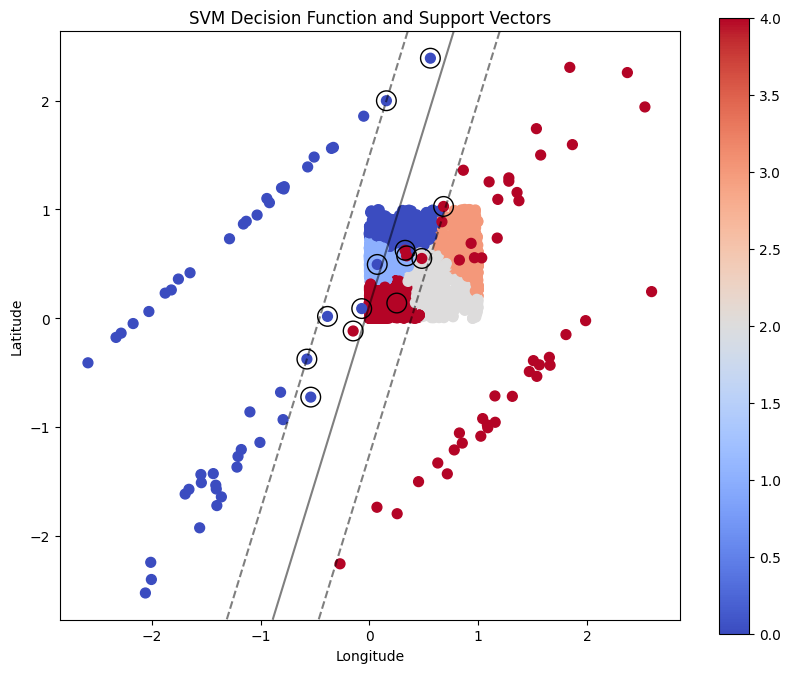

In [ ]:
gdf_loc = gpd.GeoDataFrame(df_loc, geometry=gpd.points_from_xy(df_loc.Longitude, df_loc.Latitude))

#plot the training data points
ax = gdf_loc.plot(column='Location_Class', cmap='coolwarm', legend=True, markersize=50, figsize=(10, 8))

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_loc[['Latitude', 'Longitude', 'Depth', 'Largest Magnitude']],
                                                    df_loc['Location_Class'], test_size=0.25, random_state=39)

# create and train SVM classifier
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)


#create synthetic data for illustration
X, y = datasets.make_classification(n_samples=100, n_features=2, n_classes=2, n_redundant=0, random_state=42)

#fit SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X, y)

#plot decision function and support vectors
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', marker='o', s=50)
ax = plt.gca()

xlim = ax.get_xlim()
ylim = ax.get_ylim()

#create grid to evaluate model
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
xy = np.column_stack([xx.ravel(), yy.ravel()])

#decision function result
decision_values = svm_model.decision_function(xy).reshape(xx.shape)

#plot decision boundary and margins
ax.contour(xx, yy, decision_values, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
ax.scatter(svm_model.support_vectors_[:, 0], svm_model.support_vectors_[:, 1], s=200, facecolors='none', edgecolors='k')

plt.title('SVM Decision Function and Support Vectors')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4cc02c60-5237-48e9-b623-835cdf7f4335' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>